In [51]:
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.dpi"] = 150.0

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from fakedata import *

# Starting with the simplest possible test case: fake data with no tellurics, instrumental issues, or non-Doppler-shift time variations in the spectrum

In [53]:
np.random.seed(42)
fwhms = [0.1077, 0.1113, 0.1044, 0.1083, 0.1364, 0.1, 0.1281,
                    0.1212, 0.1292, 0.1526, 0.1575, 0.1879] # FWHM of Gaussian fit to line (A)
sigs = np.asarray(fwhms) / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = [4997.967, 4998.228, 4998.543, 4999.116, 4999.508, 5000.206, 5000.348,
                5000.734, 5000.991, 5001.229, 5001.483, 5001.87] # line center (A)
ds = [-0.113524, -0.533461, -0.030569, -0.351709, -0.792123, -0.234712, -0.610711,
                -0.123613, -0.421898, -0.072386, -0.147218, -0.757536] # depth of line center (normalized flux)
ws = np.ones_like(ds) # dimensionless weights
dx = 0.01 # A
xs = np.arange(4998. + 0.5 * dx, 5002., dx) # A

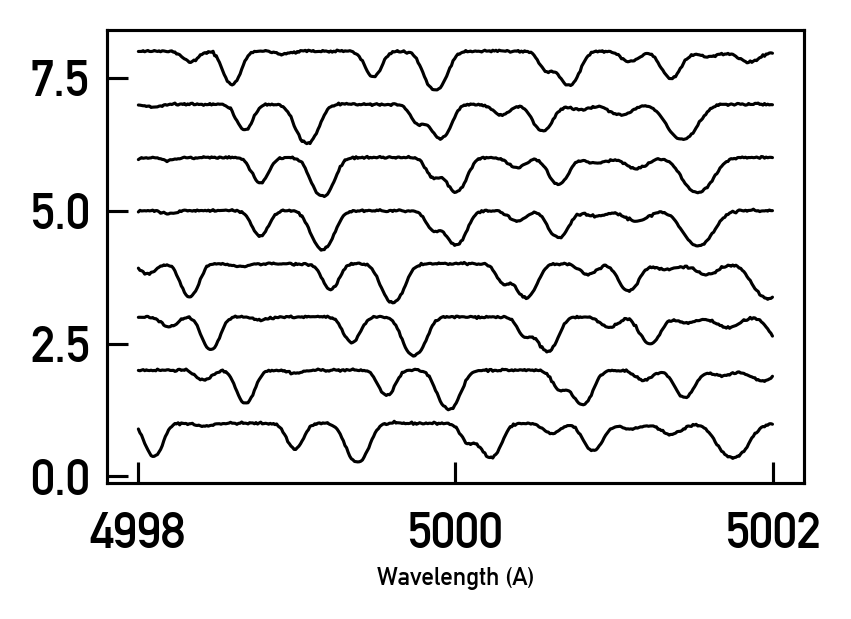

In [54]:
N = 64
data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs)
for n in range(8):
    plt.plot(xs, data[n, :] + n, color="k")
plt.xlabel('Wavelength (A)')

# Calculate the Cramer-Rao bound:

In [31]:
def dsynth_dv(rv, xs, ds, ms, sigs):
    dv = 10. # m/s
    f2 = make_synth(rv + dv, xs, ds, ms, sigs)
    f1 = make_synth(rv - dv, xs, ds, ms, sigs)
    return (f2 - f1) / (2. * dv)

def calc_crlb(xs, ds, ms, sigs, N, ivars, true_rvs):
    crlbs = np.zeros(N)
    for n in range(N): # average CRLB; averaging over true RV
        dmodel_dv = dsynth_dv(true_rvs[n], xs, ds, ms, sigs) # derivative w.r.t. RV
        crlbs[n] = np.sum(dmodel_dv * ivars[n, :] * dmodel_dv)
    crlb = 1. / np.sqrt(np.mean(crlbs))
    return crlb

In [32]:
crlb = calc_crlb(xs, ds, ms, sigs, N, ivars, true_rvs)
print "CRLB: {0:.2f} m/s".format(crlb)

CRLB: 10.87 m/s


# Can we recover this RV precision?

Method 1: binary mask cross-correlation (like the HARPS pipeline)

4998.005 5001.995
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge


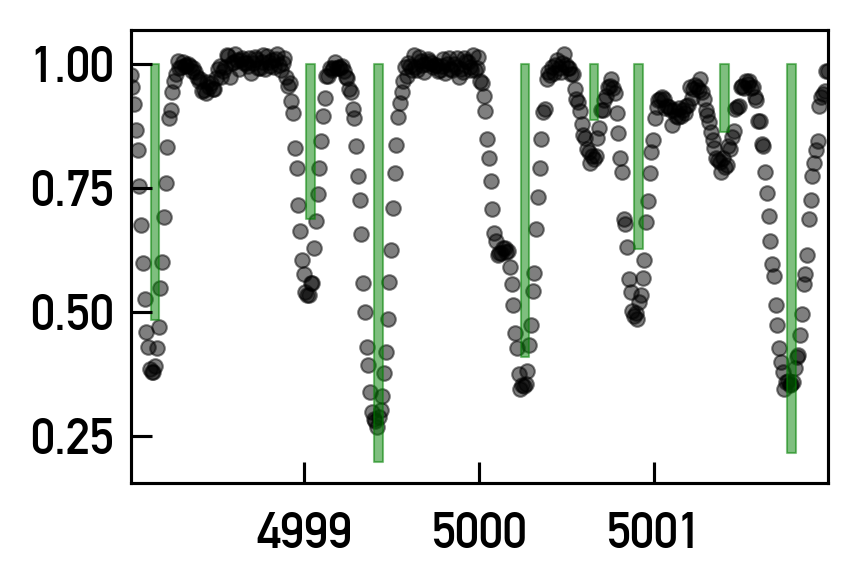

In [33]:
guess_rvs = true_rvs + np.random.normal(0., 100., size=N) # add in some random dispersion
rvs_0 = binary_xcorr(guess_rvs, xs, data, ivars, dx, ms, 
                harps_mask=True, mask_file='G2.mas')

Binary mask x-correlation: RV RMS = 143.85 m/s


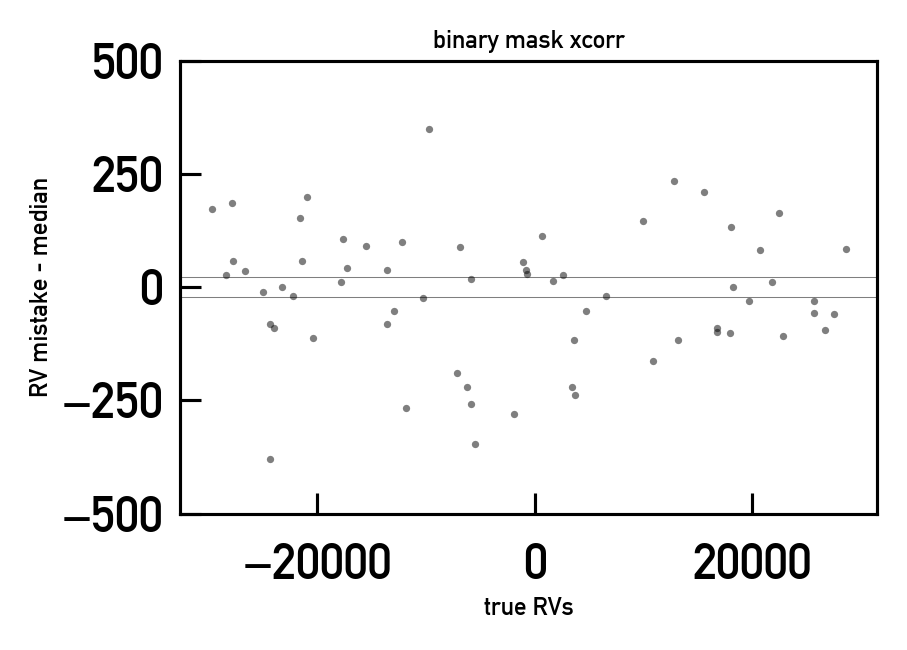

In [35]:
plot_resids(rvs_0, true_rvs, crlb=crlb, title='binary mask xcorr')
rms = np.sqrt(np.nanvar(rvs_0 - true_rvs, ddof=1)) # m/s    
print "Binary mask x-correlation: RV RMS = {0:.2f} m/s".format(rms)

Method 2: generate a stellar template from the data & fit or cross-correlate with that

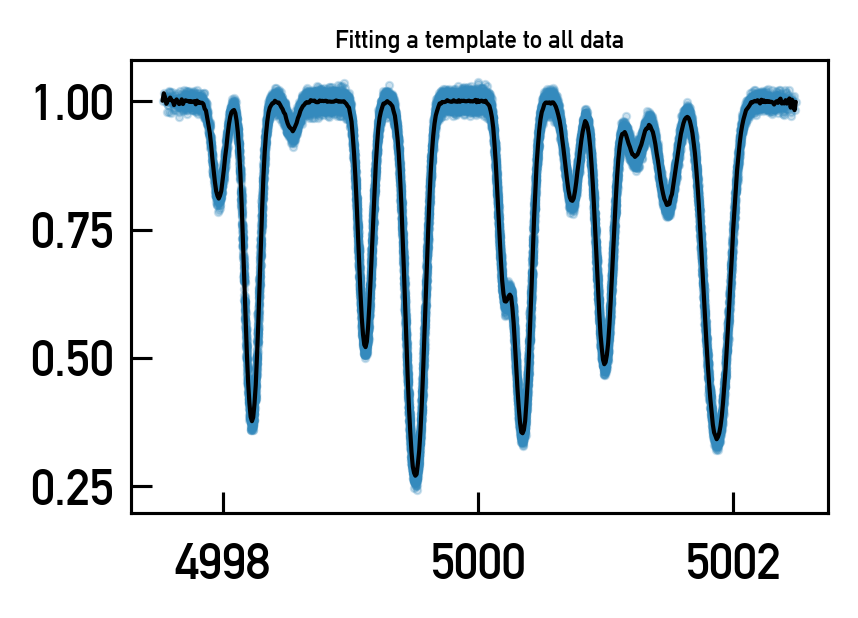

In [36]:
template_xs, template_ys = make_template(data, guess_rvs, xs, dx, plot=True)

Round 1: RV RMS = 12.72 m/s
Round 2: RV RMS = 11.00 m/s


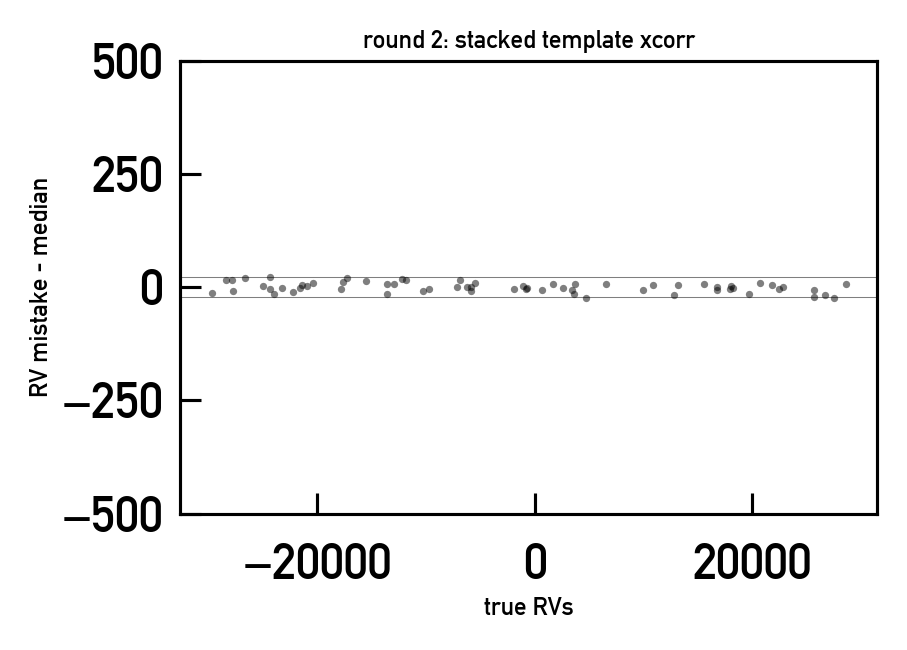

In [37]:
n_iter = 2
best_rvs = guess_rvs
for i in range(n_iter):
    template_xs, template_ys = make_template(data, best_rvs, xs, dx, plot=False)
    args = (xs, template_xs, template_ys)
    for n in range(N):
        rvs, objs = get_objective_on_grid(data[n], ivars[n], shift_template, args, xcorr, best_rvs[n], 1024.)
        rv = quadratic_max(rvs, objs)  # update best guess
        if np.isfinite(rv):
            best_rvs[n] = rv
            
            
    rms = np.sqrt(np.nanvar(best_rvs - true_rvs, ddof=1)) # m/s    
    print "Round {0}: RV RMS = {1:.2f} m/s".format(i+1, rms)
        
    plot_resids(best_rvs, true_rvs, crlb=crlb, title="round {}: stacked template xcorr".format(i+1))

Other things we have implemented:
- max-likelihood fitting instead of cross-correlation
- (very pessimistic) telluric features
- "dumb" continuum normalization

... Nothing (yet) makes the binary mask work better than the data-driven template!

# Now with real HARPS data:

In [39]:
from scipy.io.idl import readsav
from wobble import read_harps, rv_model    
data_dir = "/Users/mbedell/Documents/Research/HARPSTwins/Results/"
s = readsav(data_dir+'HIP54287_result.dat')
Star = rv_model.RV_Model()

true_rvs = ( -s.berv + s.rv - 54.9) * 1.e3  # m/s
dx = 0.01 # A
xs = np.arange(4998.0, 5002.0, dx)
N = len(s.files)  # number of epochs
M = len(xs)
data = np.empty((N, M))
ivars = np.empty_like(data)
for n,(f,b,snr) in enumerate(zip(s.files, s.berv, s.snr)):
    # read in the spectrum
    spec_file = str.replace(f, 'ccf_G2', 's1d')
    wave, spec = read_harps.read_spec(spec_file)
    # re-introduce barycentric velocity
    wave *= doppler(b*1.e3)
    # remove systemic RV shift so we're looking at the same lines as example
    wave *= doppler(54.9 * 1.e3)
    # save the relevant bit
    f = interp1d(wave, spec)
    data[n,:] = f(xs)
    ivars[n,:] = snr**2

Basic continuum normalization, plot:

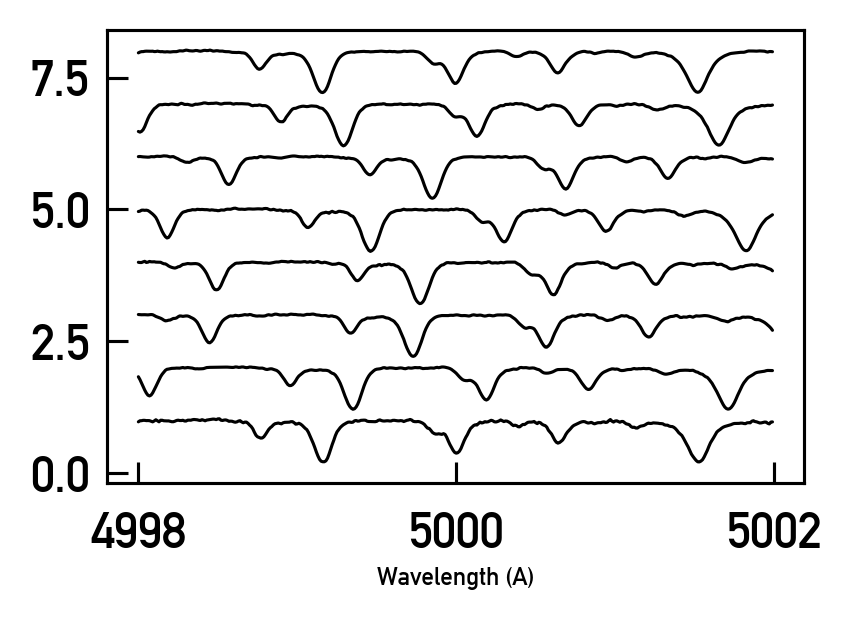

In [40]:
for n in range(N):
    data[n, :], ivars[n, :] = continuum_normalize(xs, data[n, :], ivars[n, :])
    if (n % 10. == 0.):
        plt.plot(xs, data[n, :] + n/10, color="k")
plt.xlabel('Wavelength (A)')

Try binary mask cross-correlation:

4998.0 5001.99
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge


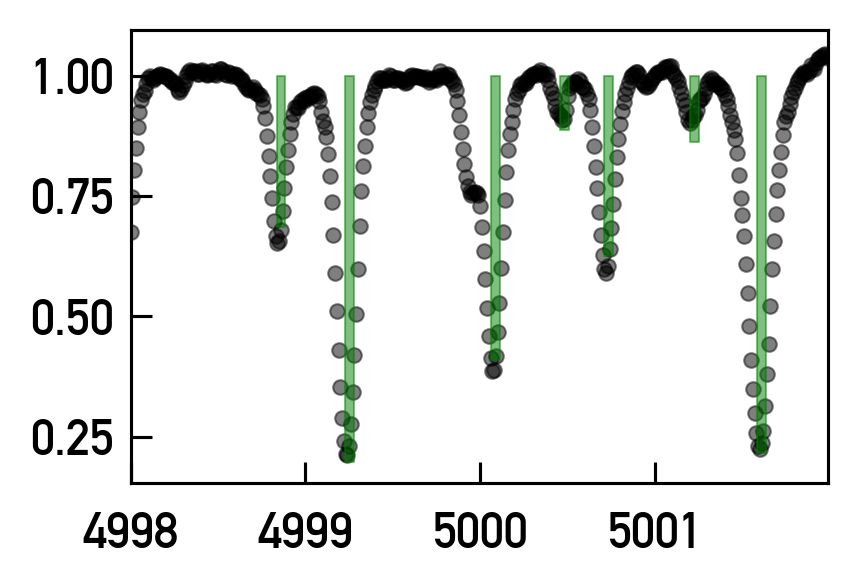

In [41]:
guess_rvs = -s.berv * 1.e3
rvs_0 = binary_xcorr(guess_rvs, xs, data, ivars, dx, ms, 
                harps_mask=True, mask_file='G2.mas')

Binary mask x-correlation: RV RMS = 106.01 m/s


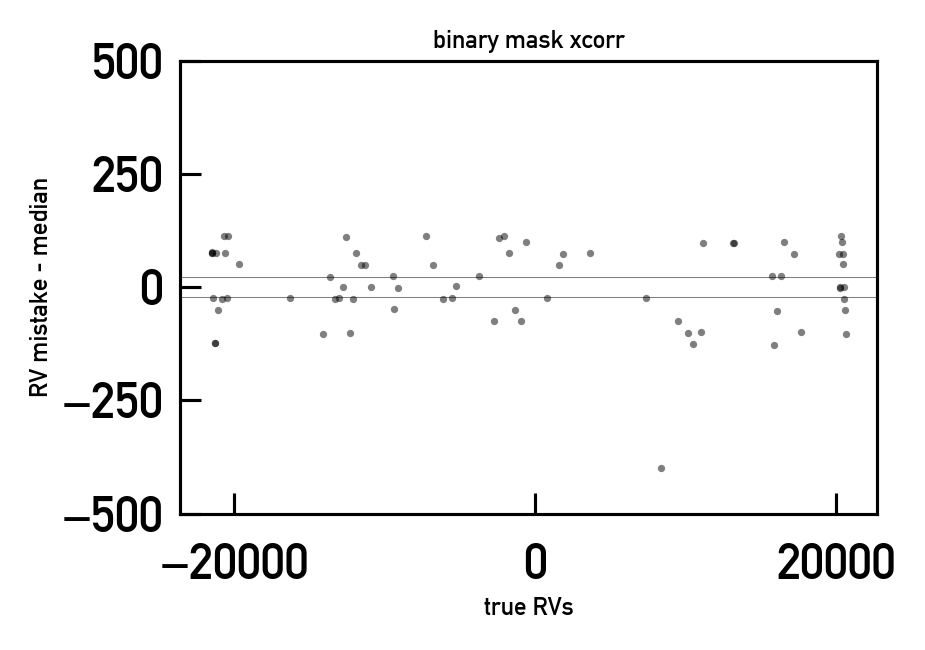

In [42]:
plot_resids(rvs_0, true_rvs, crlb=crlb, title='binary mask xcorr')
rms = np.sqrt(np.nanvar(rvs_0 - true_rvs, ddof=1)) # m/s    
print "Binary mask x-correlation: RV RMS = {0:.2f} m/s".format(rms)

Data-driven template approach:

Round 1: RV RMS = 12.44 m/s
Round 2: RV RMS = 12.63 m/s


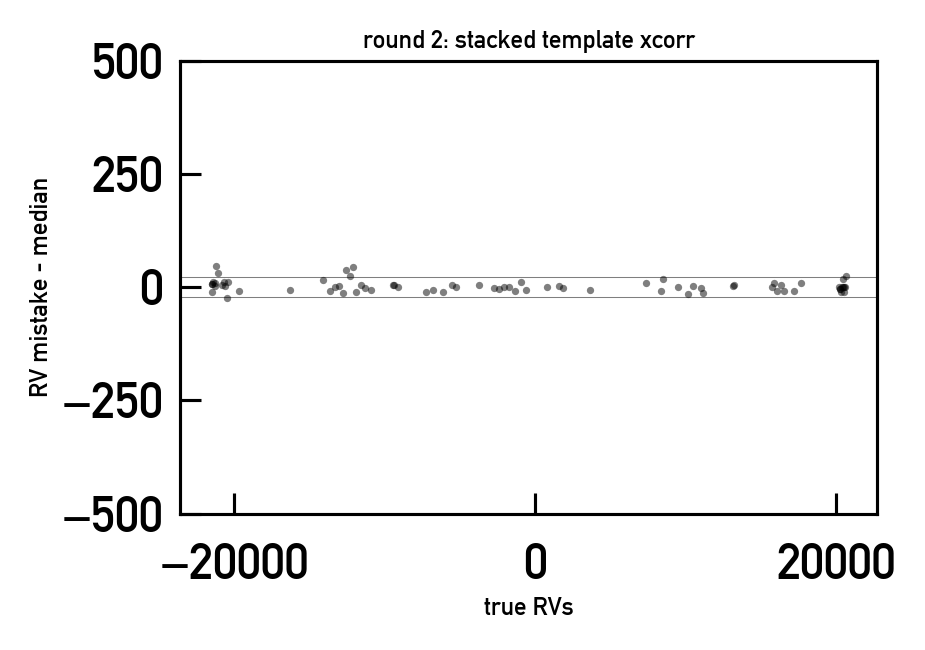

In [43]:
n_iter = 2
best_rvs = guess_rvs
for i in range(n_iter):
    template_xs, template_ys = make_template(data, best_rvs, xs, dx, plot=False)
    args = (xs, template_xs, template_ys)
    for n in range(N):
        rvs, objs = get_objective_on_grid(data[n], ivars[n], shift_template, args, xcorr, best_rvs[n], 1024.)
        rv = quadratic_max(rvs, objs)  # update best guess
        if np.isfinite(rv):
            best_rvs[n] = rv
            
            
    rms = np.sqrt(np.nanvar(best_rvs - true_rvs, ddof=1)) # m/s    
    print "Round {0}: RV RMS = {1:.2f} m/s".format(i+1, rms)
        
plot_resids(best_rvs, true_rvs, crlb=crlb, title="round {}: stacked template xcorr".format(i+1))